In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np

import rcgp.bo as bayesian_optimisation
import gpflow
import time

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
%matplotlib inline


In [109]:
class Camel:
    def __init__(self, outliers=0.1) -> None:
        self.max = 1.0316
        self.bounds = np.array([[-2.0, 2.0], [-1.0, 1.0]])
        self.dims = 2
        self.outliers = outliers
        self.name = 'Camel'
    def __call__(self, x):
        x1 = x[:,0]
        x2 = x[:,1]
        term1 = (4-2.1*x1**2+(x1**4)/3) * x1**2
        term2 = x1*x2
        term3 = (-4+4*x2**2) * x2**2
        y = term1 + term2 + term3
        if np.random.random()<self.outliers:
            y += np.random.uniform()
        return -(y.reshape(-1,1))

In [110]:
class Branin:
    def __init__(self, outliers = 0.1) -> None:
        self.max = -0.397887
        self.bounds = np.array([[-5.0, 10.0], [0.0, 15.0]])
        self.dims = 2
        self.a=1
        self.b=5.1/(4*np.pi**2)
        self.c = 5/np.pi
        self.r=6
        self.s=10
        self.t=1/(8*np.pi)
        self.name = 'Branin'
        self.outliers = outliers

    def __call__(self, x):
        x1 = x[:,0]
        x2 = x[:,1]
        term1 = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2
        term2 = self.s*(1-self.t)*np.cos(x1)
        y = term1 + term2 + self.s
        if np.random.random()<self.outliers:
            y += np.random.uniform()
        return -(y.reshape(-1,1))

In [ ]:
regrets = {'Camel':{
                    'standard':[],
                    'robust': [],
                    'student-t':[]},
            'Branin':{
                    'standard':[],
                    'robust': [],
                    'student-t':[]}}
times = {'Camel':{
                    'standard':[],
                    'robust': [],
                    'student-t':[]},
            'Branin':{
                    'standard':[],
                    'robust': [],
                    'student-t':[]}}

In [18]:
BASE_SEED = 12345
types = ['standard','robust','student-t']

functions = [ Camel(),Branin()]
#acq_function = bayesian_optimisation.AcquisitionFunction(kind="ei", xi=1)
#acq_function = bayesian_optimisation.AcquisitionFunction(kind="ucb", kappa=3)
acq_function = bayesian_optimisation.AcquisitionFunction(kind="ucb")
kernel = gpflow.kernels.SquaredExponential()
n_iter = 50
rng = np.random.default_rng(1234)
for function in functions:
    print('function', function.name)
    X_init = rng.uniform(function.bounds[:,0],function.bounds[:,1],size=(1,function.dims))
    Y_init = function(X_init)
    for type in types:
        print('BO', type)
        bo = bayesian_optimisation.BayesianOptimisation(function, 
                                                acq_function, 
                                                kernel, 
                                                gp_kind=type, 
                                                bounds=function.bounds)
        for i in range(n_iter):
            if i%10==0:
                print('Iteration',i)
            time_before = time.time()
            result = bo.optimisation(n_iter=1, X_init=X_init, Y_init=Y_init, n_restarts=2)
            time_after = time.time()
            X_init = np.vstack((bo.X_sample, bo.X_next))
            Y_init = np.vstack((bo.Y_sample, bo.Y_next))
            regrets[function.name][type].append(function.max-result[1][0])
            times[function.name][type].append(time_after-time_before)
        print(type, function, result)


function Camel
BO standard
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
standard <__main__.Camel object at 0x32e68baf0> (array([-0.13155587,  0.66994803]), array([1.00906177]))
BO robust
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
robust <__main__.Camel object at 0x32e68baf0> (array([-0.13155587,  0.66994803]), array([1.00906177]))
BO student-t
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
student-t <__main__.Camel object at 0x32e68baf0> (array([ 0.08956838, -0.70930307]), array([1.03153742]))


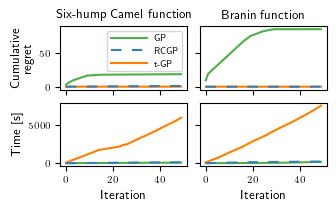

In [103]:
from tueplots import bundles
colors = ['#4daf4a', '#377eb8', '#ff7f00']
gps = ['GP', 'RCGP', 't-GP']
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True,figsize=(3.25, 2), sharey='row')
    for i, function in enumerate(functions):
        for j , type in enumerate(types):
            if type == 'robust':
                ax[0,i].plot(np.cumsum(regrets[function.name][type]),label=gps[j] , c = colors[j], ls = '--', zorder=10, dashes=(5, 5))
                ax[1,i].plot(np.cumsum(times[function.name][type]),  c = colors[j], ls = '--', zorder=10, dashes=(5, 5))
            else:
                ax[0,i].plot(np.cumsum(regrets[function.name][type]),label=gps[j] , c = colors[j])
                ax[1,i].plot(np.cumsum(times[function.name][type]),  c = colors[j])
    ax[0,0].set_title('Six-hump Camel function')
    ax[0,0].set_ylabel('Cumulative \n regret')
    ax[0,1].set_title('Branin function')
    ax[1,0].set_ylabel('Time [s]')
    ax[1,1].set_xlabel('Iteration')
    ax[1,0].set_xlabel('Iteration')
    ax[0,0].legend(fontsize=6.5, handlelength=4)
    fig.savefig('figures/bo.pdf')
plt.show()

In [95]:
import pickle 

with open('bo_times.pkl', 'wb') as f:
    pickle.dump(times, f)

with open('bo_regrets.pkl', 'wb') as f:
    pickle.dump(regrets, f)

In [131]:
with open('results/bo/bo_times.pkl', 'rb') as f:
    loaded_times = pickle.load(f)

with open('results/bo/bo_regrets.pkl', 'rb') as f:
    loaded_regrets = pickle.load(f)

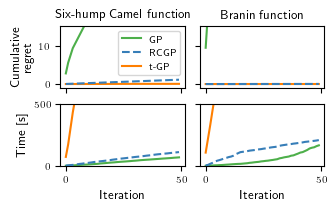

In [108]:
from tueplots import bundles
colors = ['#4daf4a', '#377eb8', '#ff7f00']
gps = ['GP', 'RCGP', 't-GP']
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True,figsize=(3.25, 2), sharey='row')
    for i, function in enumerate(functions):
        for j , type in enumerate(types):
            if type == 'robust':
                ax[0,i].plot(np.cumsum(loaded_regrets[function.name][type]),label=gps[j] , c = colors[j], ls = '--', zorder=10)
                ax[1,i].plot(np.cumsum(loaded_times[function.name][type]),  c = colors[j], ls = '--', zorder=10)
            else:
                ax[0,i].plot(np.cumsum(loaded_regrets[function.name][type]),label=gps[j] , c = colors[j])
                ax[1,i].plot(np.cumsum(loaded_times[function.name][type]),  c = colors[j])
    ax[0,0].set_title('Six-hump Camel function')
    ax[0,0].set_ylim(-1, 15)
    ax[1,1].set_ylim(-1, 500)
    ax[0,0].set_ylabel('Cumulative \n regret')
    ax[0,1].set_title('Branin function')
    ax[1,0].set_ylabel('Time [s]')
    ax[1,1].set_xlabel('Iteration')
    ax[1,0].set_xlabel('Iteration')
    ax[0,0].legend()

In [111]:
BASE_SEED = 12345
types = ['standard','robust','student-t']

functions = [ Camel(outliers=0),Branin(outliers=0)]
#acq_function = bayesian_optimisation.AcquisitionFunction(kind="ei", xi=1)
#acq_function = bayesian_optimisation.AcquisitionFunction(kind="ucb", kappa=3)
acq_function = bayesian_optimisation.AcquisitionFunction(kind="ucb")
kernel = gpflow.kernels.SquaredExponential()
n_iter = 50
rng = np.random.default_rng(1234)
for function in functions:
    print('function', function.name)
    X_init = rng.uniform(function.bounds[:,0],function.bounds[:,1],size=(1,function.dims))
    Y_init = function(X_init)
    for type in types:
        print('BO', type)
        bo = bayesian_optimisation.BayesianOptimisation(function, 
                                                acq_function, 
                                                kernel, 
                                                gp_kind=type, 
                                                bounds=function.bounds)
        for i in range(n_iter):
            if i%10==0:
                print('Iteration',i)
            time_before = time.time()
            result = bo.optimisation(n_iter=1, X_init=X_init, Y_init=Y_init, n_restarts=2)
            time_after = time.time()
            X_init = np.vstack((bo.X_sample, bo.X_next))
            Y_init = np.vstack((bo.Y_sample, bo.Y_next))
            regrets[function.name][type].append(function.max-result[1][0])
            times[function.name][type].append(time_after-time_before)
        print(type, function, result)


function Camel
BO standard
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
standard <__main__.Camel object at 0x2d92884f0> (array([ 0.08745884, -0.70431472]), array([1.03106295]))
BO robust
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
robust <__main__.Camel object at 0x2d92884f0> (array([ 0.08745884, -0.70431472]), array([1.03106295]))
BO student-t
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
student-t <__main__.Camel object at 0x2d92884f0> (array([ 0.08745884, -0.70431472]), array([1.03106295]))
function Branin
BO standard
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
standard <__main__.Branin object at 0x2d9157eb0> (array([3.13311999, 2.16894721]), array([-0.41092643]))
BO robust
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
robust <__main__.Branin object at 0x2d9157eb0> (array([3.13311999, 2.16894721]), array([-0.41092643]))
BO student-t
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iterat

In [117]:
import pickle 

with open('bo_times_no_outliers.pkl', 'wb') as f:
    pickle.dump(times, f)

with open('bo_regrets_no_outliers.pkl', 'wb') as f:
    pickle.dump(regrets, f)

In [118]:
with open('bo_times.pkl', 'rb') as f:
    loaded_times = pickle.load(f)

with open('bo_regrets.pkl', 'rb') as f:
    loaded_regrets = pickle.load(f)

In [123]:
bundles.aistats2023(column='full')

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (6.75, 4.171729424061791),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

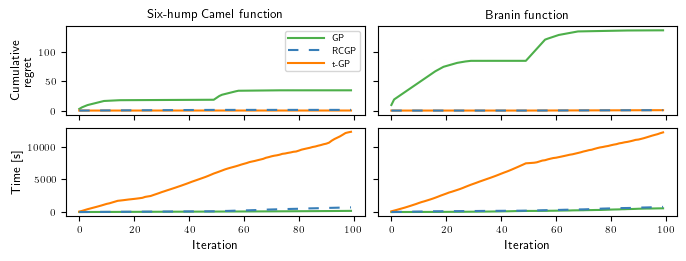

In [126]:
from tueplots import bundles
colors = ['#4daf4a', '#377eb8', '#ff7f00']
gps = ['GP', 'RCGP', 't-GP']
with plt.rc_context(bundles.aistats2023(column='full')):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6.75, 2.5), sharex=True, sharey='row')
    for i, function in enumerate(functions):
        for j , type in enumerate(types):
            if type == 'robust':
                ax[0,i].plot(np.cumsum(regrets[function.name][type]),label=gps[j] , c = colors[j], ls = '--', zorder=10, dashes=(5, 5))
                ax[1,i].plot(np.cumsum(times[function.name][type]),  c = colors[j], ls = '--', zorder=10, dashes=(5, 5))
            else:
                ax[0,i].plot(np.cumsum(regrets[function.name][type]),label=gps[j] , c = colors[j])
                ax[1,i].plot(np.cumsum(times[function.name][type]),  c = colors[j])
    ax[0,0].set_title('Six-hump Camel function')
    ax[0,0].set_ylabel('Cumulative \n regret')
    ax[0,1].set_title('Branin function')
    ax[1,0].set_ylabel('Time [s]')
    ax[1,1].set_xlabel('Iteration')
    ax[1,0].set_xlabel('Iteration')
    ax[0,0].legend(fontsize=6.5, handlelength=4)
    fig.savefig('figures/bo_no_outlier.pdf')
plt.show()